## Portfolio Exercise: Starbucks
<br>

<img src="https://opj.ca/wp-content/uploads/2018/02/New-Starbucks-Logo-1200x969.jpg" width="200" height="200">
<br>
<br>
 
#### Background Information

The dataset you will be provided in this portfolio exercise was originally used as a take-home assignment provided by Starbucks for their job candidates. The data for this exercise consists of about 120,000 data points split in a 2:1 ratio among training and test files. In the experiment simulated by the data, an advertising promotion was tested to see if it would bring more customers to purchase a specific product priced at $10. Since it costs the company 0.15 to send out each promotion, it would be best to limit that promotion only to those that are most receptive to the promotion. Each data point includes one column indicating whether or not an individual was sent a promotion for the product, and one column indicating whether or not that individual eventually purchased that product. Each individual also has seven additional features associated with them, which are provided abstractly as V1-V7.

#### Optimization Strategy

Your task is to use the training data to understand what patterns in V1-V7 to indicate that a promotion should be provided to a user. Specifically, your goal is to maximize the following metrics:

* **Incremental Response Rate (IRR)** 

IRR depicts how many more customers purchased the product with the promotion, as compared to if they didn't receive the promotion. Mathematically, it's the ratio of the number of purchasers in the promotion group to the total number of customers in the purchasers group (_treatment_) minus the ratio of the number of purchasers in the non-promotional group to the total number of customers in the non-promotional group (_control_).

$$ IRR = \frac{purch_{treat}}{cust_{treat}} - \frac{purch_{ctrl}}{cust_{ctrl}} $$


* **Net Incremental Revenue (NIR)**

NIR depicts how much is made (or lost) by sending out the promotion. Mathematically, this is 10 times the total number of purchasers that received the promotion minus 0.15 times the number of promotions sent out, minus 10 times the number of purchasers who were not given the promotion.

$$ NIR = (10\cdot purch_{treat} - 0.15 \cdot cust_{treat}) - 10 \cdot purch_{ctrl}$$

For a full description of what Starbucks provides to candidates see the [instructions available here](https://drive.google.com/open?id=18klca9Sef1Rs6q8DW4l7o349r8B70qXM).

Below you can find the training data provided.  Explore the data and different optimization strategies.

#### How To Test Your Strategy?

When you feel like you have an optimization strategy, complete the `promotion_strategy` function to pass to the `test_results` function.  
From past data, we know there are four possible outomes:

Table of actual promotion vs. predicted promotion customers:  

<table>
<tr><th></th><th colspan = '2'>Actual</th></tr>
<tr><th>Predicted</th><th>Yes</th><th>No</th></tr>
<tr><th>Yes</th><td>I</td><td>II</td></tr>
<tr><th>No</th><td>III</td><td>IV</td></tr>
</table>

The metrics are only being compared for the individuals we predict should obtain the promotion – that is, quadrants I and II.  Since the first set of individuals that receive the promotion (in the training set) receive it randomly, we can expect that quadrants I and II will have approximately equivalent participants.  

Comparing quadrant I to II then gives an idea of how well your promotion strategy will work in the future. 

Get started by reading in the data below.  See how each variable or combination of variables along with a promotion influences the chance of purchasing.  When you feel like you have a strategy for who should receive a promotion, test your strategy against the test dataset used in the final `test_results` function.

In [1]:
# load in packages
from itertools import combinations

from test_results import test_results, score
import numpy as np
import pandas as pd
import scipy.stats as stats
import sklearn as sk

import matplotlib.pyplot as plt
# import seaborn as sb
%matplotlib inline

# define a numpy generator
seed = 50
np_generator = np.random.default_rng(seed)

# load in the data
train_data = pd.read_csv('./training.csv')
train_data.head()

,ID,Promotion,purchase,V1,V2,V3,V4,V5,V6,V7
0,1,No,0,2,30.443518,-1.165083,1,1,3,2
1,3,No,0,3,32.159350,-0.645617,2,3,2,2
2,4,No,0,2,30.431659,0.133583,1,1,4,2
3,5,No,0,0,26.588914,-0.212728,2,1,4,2
4,8,Yes,0,3,28.044331,-0.385883,1,1,2,2


# Exploring the dataset

In [2]:
train_data.shape

(84534, 10)

In [3]:
train_data.dtypes

ID             int64
Promotion     object
purchase       int64
V1             int64
V2           float64
V3           float64
V4             int64
V5             int64
V6             int64
V7             int64
dtype: object

In [4]:
train_data.describe()

,ID,purchase,V1,V2,V3,V4,V5,V6,V7
count,84534.000000,84534.000000,84534.000000,84534.000000,84534.000000,84534.000000,84534.000000,84534.000000,84534.000000
mean,62970.972413,0.012303,1.500662,29.973600,0.000190,1.679608,2.327643,2.502898,1.701694
std,36418.440539,0.110234,0.868234,5.010626,1.000485,0.466630,0.841167,1.117349,0.457517
min,1.000000,0.000000,0.000000,7.104007,-1.684550,1.000000,1.000000,1.000000,1.000000
25%,31467.250000,0.000000,1.000000,26.591501,-0.905350,1.000000,2.000000,2.000000,1.000000
50%,62827.500000,0.000000,2.000000,29.979744,-0.039572,2.000000,2.000000,3.000000,2.000000
75%,94438.750000,0.000000,2.000000,33.344593,0.826206,2.000000,3.000000,4.000000,2.000000
max,126184.000000,1.000000,3.000000,50.375913,1.691984,2.000000,4.000000,4.000000,2.000000


In [5]:
### Check if exist null values
train_data.isnull().sum()

ID           0
Promotion    0
purchase     0
V1           0
V2           0
V3           0
V4           0
V5           0
V6           0
V7           0
dtype: int64

# Statistical Analysis

Statistical significance of the invariant variable
$$ H_0: n_{ctrl} - n_{prom} = 0$$
$$ H_1: n_{ctrl} - n_{prom} \not= 0$$
$$ \alpha = 0.05 $$

#### Analytical approach

In [12]:
n_total = train_data.shape[0]
n_ctrl = train_data.query('Promotion == "No"').shape[0]

# The probability of each value is 50%
p_null = 0.5

sd = np.sqrt(p_null * (1 - p_null) * n_total)
z_score = ((n_ctrl + 0.5) - 0.5 * n_total) / sd
analytical_p_value = 2 * stats.norm.cdf(z_score)

print('By the analytical approach the p-value is {:.4f}'.format(analytical_p_value))

By the analytical approach the p-value is 0.5068


#### Simulation approach

In [8]:
n_samples = 1000
alpha = 0.05
confidence_level = 1 - alpha

data_numbers = train_data['Promotion'].replace(['No', 'Yes'], [-1, 1])
samples = np_generator.choice(data_numbers, replace=True, size=(n_total, n_samples))
diffs = samples.sum(axis=0)

null_mean = 0
obs_diff = data_numbers.sum()

# determining the confidence interval
upper_bound = np.percentile(diffs, (1 + confidence_level)/2 * 100)
lower_bound = np.percentile(diffs, (1 - confidence_level)/2 * 100)

print('With a Type I error of {}, the confidence interval is between {:.2f} and {:.2f}'.format(alpha, lower_bound, upper_bound))

With a Type I error of 0.05, the confidence interval is between -356.00 and 734.15


Plotting the distributtion of the Null Hypothesis

In [9]:
sample_std = np.std(diffs)
null_vals = np_generator.normal(null_mean, sample_std, n_samples*10)

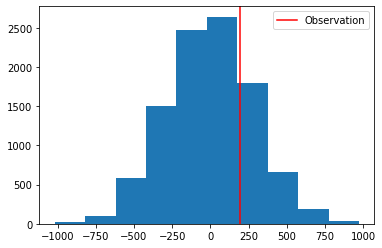

In [10]:
plt.hist(null_vals);
plt.axvline(obs_diff, color='r', label='Observation');
plt.legend();

In [13]:
# for a two sided hypothesis, we want to look at anything 
# more extreme from the null in both directions

# probability of a statistic higher than observed
prob_more_extreme_high = (null_vals > obs_diff).mean()
    
# probability a statistic is more extreme lower
prob_more_extreme_low = (null_mean - (obs_diff - null_mean) > null_vals).mean()

simultaion_p_value = prob_more_extreme_low + prob_more_extreme_high

print('By the simulation approach the p-value is {:.4f}'.format(simultaion_p_value))

By the simulation approach the p-value is 0.5014


Considering the analytical and simulation p-values above 0.5 we could **not** reject the null hypothesis.

So the variation in the invariant metric is not statistically relevant.

With this we can continue no analyze the variant métrics.

# Analyzing the Variant Métrics

### Define the metrics

In [17]:
def calc_irr(df):
    """ Calculate the Incremental Response Rate (IRR) métric
    
    Arguments:
    df (Dataframe): the dataframe containing the data about the promotions
    
    Output:
    irr (float): the metric calculation
    """
    
    n_ctrl = df.query('Promotion == "No"').shape[0]
    n_prom = df.query('Promotion == "Yes"').shape[0]
    n_purch_ctrl = df.query('Promotion == "No"')['purchase'].sum()
    n_purch_prom = df.query('Promotion == "Yes"')['purchase'].sum()
    
    return (n_purch_prom / n_prom) - (n_purch_ctrl / n_ctrl)

In [18]:
def calc_nir(df):
    """ Calculate the Net Incremental Revenue (NIR) métric
    
    Arguments:
    df (Dataframe): the dataframe containing the data about the promotions
    
    Output:
    nir (float): the metric calculation
    """
    
    n_prom = df.query('Promotion == "Yes"').shape[0]
    n_purch_ctrl = df.query('Promotion == "No"')['purchase'].sum()
    n_purch_prom = df.query('Promotion == "Yes"')['purchase'].sum()
    
    return 10 * n_purch_prom - 0.15 * n_prom - 10 * n_purch_ctrl

In [19]:
### Calculating the métrics for the train_data
irr = calc_irr(train_data)
nir = calc_nir(train_data)

print('The train data has a IRR of {:.4f} and a NIR of {:.4f}'.format(irr, nir))

The train data has a IRR of 0.0095 and a NIR of -2334.6000


### Analyzing the Hypothesis

$$ \alpha = 0.05 $$

In [23]:
### Defining default variables and fucntions
n_samples, n_total, null_mean

(1000, 84534, 0)

#### Incremental Response Rate (IRR)

$$ H_0: IRR \leqslant 0$$
$$ H_1: IRR > 0$$

In [38]:
irrs = []

for _ in range(n_samples):
    sample = train_data.sample(n_total, replace=True)
    irr = calc_irr(sample)
    irrs.append(irr)
    
upper_bound = np.percentile(irrs, (1 + confidence_level)/2 * 100)
lower_bound = np.percentile(irrs, (1 - confidence_level)/2 * 100)

print('With a Type I error of {}, the confidence interval is between {:.4f} and {:.4f}'.format(alpha, lower_bound, upper_bound))

With a Type I error of 0.05, the confidence interval is between 0.0080 and 0.0109


In [24]:
irr_std = np.std(irrs)
irr_mean = np.mean(irrs)
irr_null_vals = np_generator.normal(null_mean, irr_std, n_samples*10)

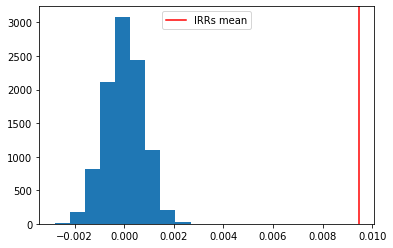

In [39]:
plt.hist(irr_null_vals);
plt.axvline(irr_mean, color='r', label='IRRs mean');
plt.legend();

In [40]:
### Calculating the p-value
(irr_null_vals > irr_mean).mean()

0.0

#### Net Incremental Revenue (NIR)

$$ H_0: NIR \leqslant 0$$
$$ H_1: NIR > 0$$

In [42]:
nirs = []

for _ in range(n_samples):
    sample = train_data.sample(n_total, replace=True)
    nir = calc_nir(sample)
    nirs.append(nir)
    
upper_bound = np.percentile(nirs, (1 + confidence_level)/2 * 100)
lower_bound = np.percentile(nirs, (1 - confidence_level)/2 * 100)

print('With a Type I error of {}, the confidence interval is between {:.4f} and {:.4f}'.format(alpha, lower_bound, upper_bound))

With a Type I error of 0.05, the confidence interval is between -2951.2175 and -1736.6500


In [43]:
nir_std = np.std(nirs)
nir_mean = np.mean(nirs)
nir_null_vals = np_generator.normal(null_mean, nir_std, n_samples*10)

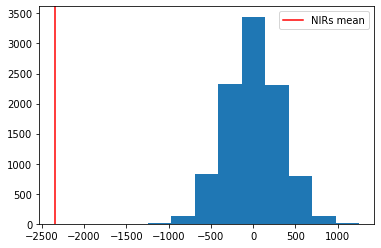

In [44]:
plt.hist(nir_null_vals);
plt.axvline(nir_mean, color='r', label='NIRs mean');
plt.legend();

In [45]:
### Calculating the p-value
(nir_null_vals > nir_mean).mean()

1.0

# The Machine Learning Model

In [2]:
train_data.head()

,ID,Promotion,purchase,V1,V2,V3,V4,V5,V6,V7
0,1,No,0,2,30.443518,-1.165083,1,1,3,2
1,3,No,0,3,32.159350,-0.645617,2,3,2,2
2,4,No,0,2,30.431659,0.133583,1,1,4,2
3,5,No,0,0,26.588914,-0.212728,2,1,4,2
4,8,Yes,0,3,28.044331,-0.385883,1,1,2,2


In [61]:
df_promotion = train_data.query('Promotion == "Yes"').reset_index()

X = df_promotion.drop(columns=['ID', 'Promotion', 'purchase', 'index'])
y = df_promotion['purchase']

In [62]:
from sklearn.model_selection import train_test_split

In [87]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=seed)

In [75]:
### Balancing the dataset
from imblearn.over_sampling import SMOTE

In [88]:
smote = SMOTE()
X_smote, y_smote = smote.fit_resample(X_train, y_train)

y_smote.value_counts()

0    31238
1    31238
Name: purchase, dtype: int64

In [70]:
### Taining the model
from sklearn.ensemble import RandomForestClassifier
# from sklearn.svm import SVC
from sklearn.metrics import classification_report

In [93]:
model = RandomForestClassifier(max_depth=7, class_weight='balanced', random_state=seed)
# model = SVC(class_weight='balanced', random_state=seed)
model.fit(X_smote, y_smote)
preds = model.predict(X_test)
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.99      0.58      0.73     10405
           1       0.02      0.55      0.04       186

    accuracy                           0.58     10591
   macro avg       0.50      0.57      0.39     10591
weighted avg       0.97      0.58      0.72     10591



In [67]:
def promotion_strategy(df):
    '''
    INPUT 
    df - a dataframe with *only* the columns V1 - V7 (same as train_data)

    OUTPUT
    promotion_df - np.array with the values
                   'Yes' or 'No' related to whether or not an 
                   individual should recieve a promotion 
                   should be the length of df.shape[0]
                
    Ex:
    INPUT: df
    
    V1	V2	  V3	V4	V5	V6	V7
    2	30	-1.1	1	1	3	2
    3	32	-0.6	2	3	2	2
    2	30	0.13	1	1	4	2
    
    OUTPUT: promotion
    
    array(['Yes', 'Yes', 'No'])
    indicating the first two users would recieve the promotion and 
    the last should not.
    '''
    
    preds = model.predict(df)
    
    return np.where(preds == 0, 'No', 'Yes')

In [94]:
# This will test your results, and provide you back some information 
# on how well your promotion_strategy will work in practice

test_results(promotion_strategy)

Nice job!  See how well your strategy worked on our test data below!

Your irr with this strategy is 0.0155.

Your nir with this strategy is 30.65.
We came up with a model with an irr of 0.0188 and an nir of 189.45 on the test set.

 How did you do?


(0.015472289657089295, 30.65000000000009)